In [1]:
!pip install unityagents

    100% |████████████████████████████████| 81kB 5.3MB/s ta 0:00:011
    100% |████████████████████████████████| 48.1MB 902kB/s eta 0:00:01  3% |█                               | 1.6MB 26.7MB/s eta 0:00:02    8% |██▉                             | 4.3MB 28.3MB/s eta 0:00:02    14% |████▊                           | 7.0MB 27.4MB/s eta 0:00:02    25% |████████                        | 12.1MB 26.4MB/s eta 0:00:02    35% |███████████▎                    | 16.9MB 25.3MB/s eta 0:00:02    37% |████████████▏                   | 18.2MB 26.1MB/s eta 0:00:02    40% |█████████████                   | 19.5MB 26.5MB/s eta 0:00:02    43% |█████████████▉                  | 20.7MB 26.4MB/s eta 0:00:02    48% |███████████████▍                | 23.2MB 25.8MB/s eta 0:00:01    56% |██████████████████              | 27.0MB 25.6MB/s eta 0:00:01    71% |██████████████████████▉         | 34.3MB 24.7MB/s eta 0:00:01    73% |███████████████████████▋        | 35.5MB 24.2MB/s eta 0:00:01
    100% |█████████████████

# Deep Q-Network Architecture

The network is something like this:

1) input_size = state_size = 37

2) linear layers, one with 128 nodes as output and other with 64 nodes as output with relu activation for both

3) A third linear layer with 4 outputs for 4 actions

### Learning algo to use

The algo used in this project will be Q-learning algo with experience relay and fixed Q targets. The optimization of network will be done through Adam optimizer

### Hyperparameters used

BUFFER_SIZE = int(1e5) : replay buffer size

BATCH_SIZE = 64 : minibatch size

GAMMA = 0.99 : discount factor

TAU = 1e-3 : for soft update of target parameters

LR = 5e-4 : learning rate

UPDATE_EVERY = 4 : how often to update the network

EPS_DECAY=0.995 : the reduction factor of the epsilon-greedy policy

# Import the Necessary Packages

In [2]:
from dqn_agent import Agent
from collections import deque
from unityagents import UnityEnvironment

import numpy as np
import random 
import os
import torch
import matplotlib.pyplot as plt



# Environment Information

In [3]:
## Choose your operating system:
#      mac
#      windows_x86
#      windows_x86_64
#      linux_x86
#      linux_x86_64

env = UnityEnvironment(file_name='/data/Banana_Linux_NoVis/Banana.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain:', brain_name)

Brain: BananaBrain


# Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:

• 0 - walk forward

• 1 - walk backward

• 2 - turn left

• 3 - turn right


The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#number of agents in the environment
print('Number of agents:', len(env_info.agents))

#number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

#examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('State have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
State have length: 37


# DQN Function

Trains the agent over a maximum number of episodes until the target score is reached.

In [6]:
TARGET_SCORE = 13.0

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    """Deep Q-Learning 
        Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    mean_scores = []                   # list the mean of the window scores
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info= env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores.append(score)
        scores_window.append(score)
        mean_score = np.mean(scores_window)
        mean_scores.append(mean_score)
        
        eps = max(eps_end, eps_decay*eps)   
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        
        if mean_score >= TARGET_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            break
                
    return scores, mean_scores
            
            

# Train Function 

Trains the agent over a maximum number of episodes until the target score is reached and plots the scores.

In [7]:
def train(agent, weights_file):
    scores, means = dqn(agent, n_episodes=1000, max_t=500, eps_start=0.10, eps_end=0.01, eps_decay=0.98)
    agent.save(weights_file)

    # plot the scores
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(means)), means, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(('Score', 'Mean'), fontsize='xx-large')
    plt.show()

# Evaluation Function

Evaluates a trained agent over a number of episodes and plots the scores.

In [18]:
def evaluate(env, agent, episodes, weights_file):
    
    # load trained weights from file
    agent.load(weights_file)
    
    scores = []  # list containing scores from each episode

    for i_episode in range(1, episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state    
        score = 0    
        while True:
            action = agent.act(state)                      # get the next action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]  
            score += reward 
            state = next_state
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
            if done:
                break 

        scores.append(score)  # save most recent score

        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, scores[-1]))
    
    mean_score = np.mean(scores)
    print('\nAverage Score over {} episodes: {:.2f}!'.format(episodes, mean_score))

    # plot the scores
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(scores)), [np.mean(scores)]*len(scores), linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(('Score', 'Mean'), fontsize='xx-large')
    plt.show()
    

# Training and Evaluation

Train and evaluate agent using DQN method and optimization.Agent were trained until it achieved the mean target score of 13.0 over 100 consecutive episodes. For the evaluation, the mean score was determined over exactly 100 consecutive episodes.

In [9]:
state_size = 37
action_size = 4
agent = Agent(state_size=state_size, action_size=action_size, seed=0, fc1_units=64, fc2_units=64)
weights_file = 'weights/checkpoint.pth'

Episode 100	Average Score: 4.52
Episode 200	Average Score: 8.38
Episode 295	Average Score: 13.04
Environment solved in 295 episodes!	Average Score: 13.04


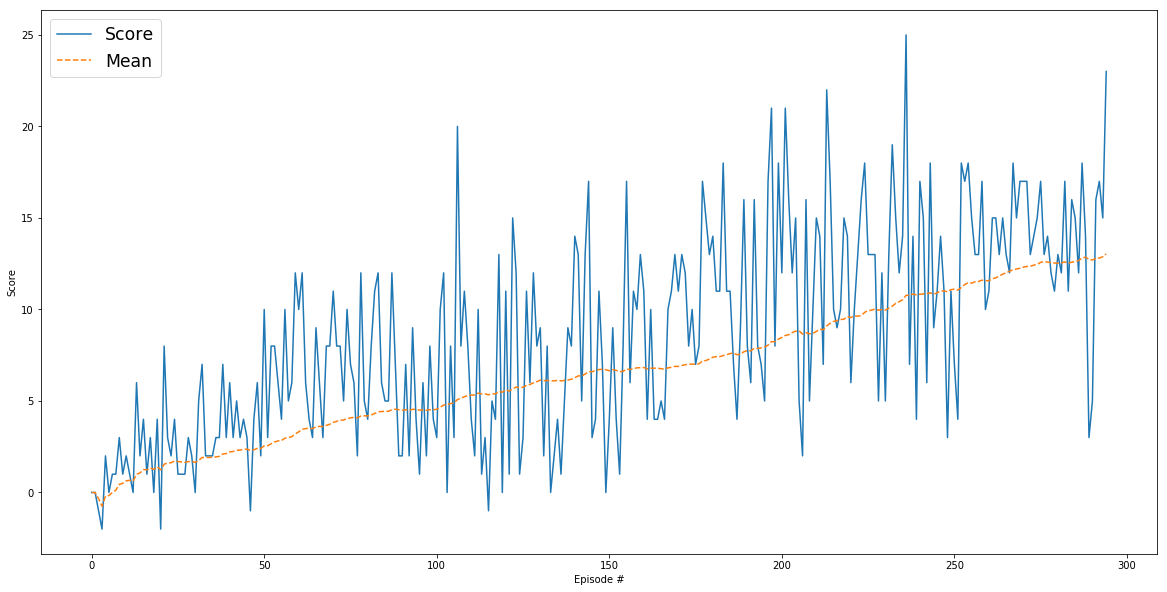

In [10]:
train(agent, weights_file)

Episode 1	Score: 23.00
Episode 2	Score: 14.00
Episode 3	Score: 4.00
Episode 4	Score: 14.00
Episode 5	Score: 20.00
Episode 6	Score: 16.00
Episode 7	Score: 13.00
Episode 8	Score: 14.00
Episode 9	Score: 6.00
Episode 10	Score: 16.00
Episode 11	Score: 12.00
Episode 12	Score: 16.00
Episode 13	Score: 16.00
Episode 14	Score: 15.00
Episode 15	Score: 21.00
Episode 16	Score: 20.00
Episode 17	Score: 18.00
Episode 18	Score: 15.00
Episode 19	Score: 19.00
Episode 20	Score: 19.00
Episode 21	Score: 13.00
Episode 22	Score: 19.00
Episode 23	Score: 19.00
Episode 24	Score: 20.00
Episode 25	Score: 14.00
Episode 26	Score: 19.00
Episode 27	Score: 3.00
Episode 28	Score: 19.00
Episode 29	Score: 15.00
Episode 30	Score: 16.00
Episode 31	Score: 18.00
Episode 32	Score: 19.00
Episode 33	Score: 24.00
Episode 34	Score: 18.00
Episode 35	Score: 16.00
Episode 36	Score: 16.00
Episode 37	Score: 13.00
Episode 38	Score: 15.00
Episode 39	Score: 13.00
Episode 40	Score: 23.00
Episode 41	Score: 17.00
Episode 42	Score: 19.00
Epis

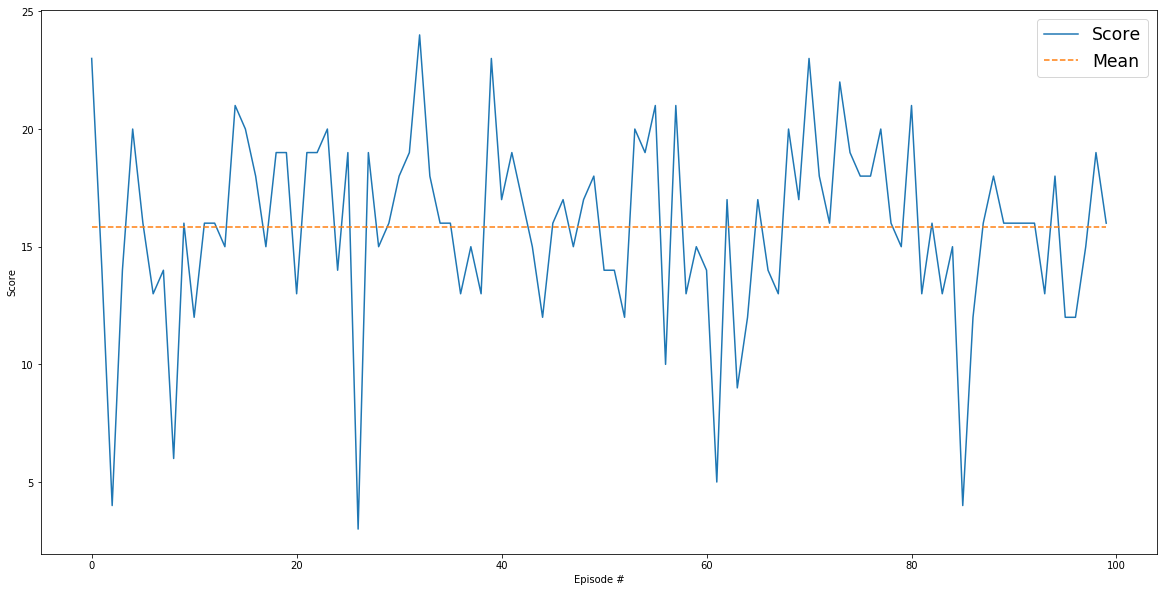

In [19]:
evaluate(env, agent, episodes=100, weights_file=weights_file)

In [20]:
env.close()

# Future work to consider:

I'm planning to add following features in this:

• Duelling DQN

• Double DQN

• Prioritized Experienced Replay